# Stage I: Physical Features for KMeans Clustering

This notebook builds the physical feature matrix for Stage I KMeans clustering by querying DuckDB views.

**Features:**
- `age`: years since installation (2024 – installation year, with fractional precision)
- `diameter`: physical diameter of the meter (`DIAM_COMP`)
- `canya`: proxy for accumulated consumption (median of yearly averages × age)
- `brand_model`: joint categorical label for `MARCA_COMP` + `CODI_MODEL` (one-hot encoded)

**Normalization:**
- `age` and `diameter`: min-max scaling [0, 1]
- `canya`: z-score (standardization, mean=0, std=1)
- `brand_model`: one-hot encoding (27 categories)


In [2]:
# Imports and constants
from __future__ import annotations

from pathlib import Path
from typing import Iterable, Tuple

import duckdb
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

CURRENT_YEAR = 2024
DEFAULT_DB_PATH = Path("..") / "analytics.duckdb"  # Relative to notebook location
NUMERIC_FEATURES = ["age", "diameter", "canya"]


## Function: Compute Physical Features

Queries DuckDB to extract raw physical features for domestic meters.


In [3]:
def compute_physical_features(
    *,
    db_path: str | Path = DEFAULT_DB_PATH,
    current_year: int = CURRENT_YEAR,
) -> pd.DataFrame:
    """
    Compute physical features required by Stage I.

    Parameters
    ----------
    db_path:
        Path to ``analytics.duckdb`` containing the required views.
    current_year:
        Reference year used to compute meter age. Defaults to 2024.

    Returns
    -------
    pandas.DataFrame
        DataFrame indexed by meter id with the columns:
        ``age``, ``diameter``, ``canya``, ``brand_model``.
    """

    path = Path(db_path)
    if not path.exists():
        raise FileNotFoundError(
            f"DuckDB database not found at {path}. "
            "Run data/create_database.py to generate analytics.duckdb."
        )

    con = duckdb.connect(database=str(path), read_only=True)

    sql = """
    WITH metadata AS (
        -- First, get all domestic meters from counter_metadata
        -- This preserves ALL brand_model combinations
        SELECT
            "POLIZA_SUMINISTRO"::VARCHAR AS meter_id,
            CAST(DATA_INST_COMP AS DATE) AS installation_date,
            CAST(DIAM_COMP AS DOUBLE) AS diameter,
            CAST(MARCA_COMP AS VARCHAR) AS marca_comp,
            CAST(CODI_MODEL AS VARCHAR) AS codi_model
        FROM counter_metadata
        WHERE US_AIGUA_GEST = 'D'
    ),
    consumption_with_metadata AS (
        -- LEFT JOIN to consumption_data to preserve all meters
        SELECT
            m.meter_id,
            m.installation_date,
            m.diameter,
            m.marca_comp,
            m.codi_model,
            CAST(cd.FECHA AS DATE) AS fecha,
            cd.CONSUMO_REAL
        FROM metadata m
        LEFT JOIN consumption_data cd
            ON m.meter_id = cd."POLIZA_SUMINISTRO"
    ),
    yearly AS (
        -- Aggregate consumption by year (only for meters with consumption data)
        SELECT
            meter_id,
            EXTRACT(YEAR FROM fecha) AS year,
            AVG(CONSUMO_REAL) AS avg_consumption
        FROM consumption_with_metadata
        WHERE fecha IS NOT NULL AND CONSUMO_REAL IS NOT NULL
        GROUP BY meter_id, year
    ),
    avg_yearly AS (
        SELECT
            meter_id,
            AVG(avg_consumption) AS avg_yearly
        FROM yearly
        GROUP BY meter_id
    ),
    median_yearly AS (
        SELECT
            meter_id,
            MEDIAN(avg_consumption) AS median_yearly
        FROM yearly
        GROUP BY meter_id
    )
    SELECT
        m.meter_id,
        m.installation_date,
        m.diameter,
        m.marca_comp,
        m.codi_model,
        COALESCE(a.avg_yearly, 0) AS avg_yearly,
        COALESCE(md.median_yearly, 0) AS median_yearly
    FROM metadata m
    LEFT JOIN avg_yearly a USING (meter_id)
    LEFT JOIN median_yearly md USING (meter_id)
    """

    df = con.execute(sql).df()
    con.close()

    if df.empty:
        raise ValueError("No domestic meters found with the specified filter.")

    df["installation_date"] = pd.to_datetime(df["installation_date"], errors="coerce")

    reference_date = pd.Timestamp(year=current_year, month=12, day=31)
    days_since_install = (reference_date - df["installation_date"]).dt.days
    df["age"] = (days_since_install / 365.25).clip(lower=0)
    df["diameter"] = df["diameter"].astype(float)

    df["canya"] = df["median_yearly"].fillna(0) * df["age"]

    df["marca_comp"] = df["marca_comp"].astype(str).str.strip()
    df["codi_model"] = df["codi_model"].astype(str).str.strip()
    df["brand_model"] = (
        df["marca_comp"].fillna("UNK") + "::" + df["codi_model"].fillna("UNK")
    )

    final_columns: Iterable[str] = [
        "meter_id",
        "age",
        "diameter",
        "canya",
        "brand_model",
        "avg_yearly",
        "median_yearly",
    ]

    df = df.loc[:, final_columns]

    return df


## Function: Build Stage I Feature Matrix

Constructs the normalized + one-hot encoded feature matrix for Stage I KMeans.


In [4]:
def build_stage1_feature_matrix(
    *,
    db_path: str | Path = DEFAULT_DB_PATH,
    current_year: int = CURRENT_YEAR,
) -> Tuple[pd.DataFrame, MinMaxScaler, StandardScaler, OneHotEncoder]:
    """
    Construct the normalized + one-hot encoded feature matrix for Stage I.
    
    Uses min-max scaling for age and diameter, z-score (standardization) for canya.

    Returns
    -------
    tuple
        (features_df, fitted_minmax_scaler, fitted_standard_scaler, fitted_onehot_encoder)
    """

    raw_features = compute_physical_features(db_path=db_path, current_year=current_year)

    # Min-max scaling for age and diameter
    minmax_scaler = MinMaxScaler()
    age_diameter_scaled = minmax_scaler.fit_transform(raw_features[["age", "diameter"]])
    age_diameter_df = pd.DataFrame(
        age_diameter_scaled, 
        columns=["age", "diameter"], 
        index=raw_features.index
    )
    
    # Z-score (standardization) for canya
    standard_scaler = StandardScaler()
    canya_scaled = standard_scaler.fit_transform(raw_features[["canya"]])
    canya_df = pd.DataFrame(
        canya_scaled,
        columns=["canya"],
        index=raw_features.index
    )
    
    # Combine scaled numeric features
    scaled_df = pd.concat([age_diameter_df, canya_df], axis=1)

    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    brand_encoded = encoder.fit_transform(raw_features[["brand_model"]])
    brand_columns = [f"brand_model__{cat}" for cat in encoder.categories_[0]]
    brand_df = pd.DataFrame(brand_encoded, columns=brand_columns, index=raw_features.index)

    features = pd.concat(
        [
            raw_features[["meter_id"]],
            scaled_df,
            brand_df,
        ],
        axis=1,
    )

    return features, minmax_scaler, standard_scaler, encoder


In [8]:
# Build the feature matrix
features, minmax_scaler, standard_scaler, encoder = build_stage1_feature_matrix()

# Summary
num_brand_cols = sum(col.startswith("brand_model__") for col in features.columns)
print(f"Feature matrix shape: {features.shape}")
print(f"Numeric columns: {NUMERIC_FEATURES}")
print(f"Brand model OHE columns: {num_brand_cols}")
print(f"\nTotal domestic meters: {len(features):,}")


Feature matrix shape: (10427, 21)
Numeric columns: ['age', 'diameter', 'canya']
Brand model OHE columns: 17

Total domestic meters: 10,427


## Preview: Feature Matrix

Display first few rows and basic statistics.


In [9]:
# Preview the feature matrix
features.head(10)


,meter_id,age,diameter,canya,brand_model__IBE::66,brand_model__IBE::73,brand_model__ITR::2,brand_model__ITR::21,brand_model__ITR::22,brand_model__ITR::23,...,brand_model__ITR::45,brand_model__ITR::48,brand_model__ITR::50,brand_model__ITR::63,brand_model__SPL::2,brand_model__SPL::4,brand_model__ZAR::19,brand_model__ZAR::21,brand_model__ZAR::27,brand_model__ZAR::46
0,ZIBHE3GN5LFH4L6V,0.388537,0.0,-0.258759,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZIHVIJXERNJ6AOMJ,0.172775,0.0,-0.743521,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ZIIE4TD22CQE4NPL,0.697437,0.0,1.015466,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZIJW7AFK2MYR5EXS,0.593552,0.0,-0.560041,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,ZIPTYOUIIO2L2AN4,0.446404,0.0,-0.653991,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ZIXRE53OXGMWRX6C,0.522458,0.0,0.698721,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,ZJ3HQTVHAZKNGNAI,0.380821,0.0,1.531902,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,ZJ46IQQU3ROE4UYK,0.117112,0.0,-0.191995,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,ZJBDD6LPIYTGRZRC,0.552494,0.0,-0.488279,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,ZJC64FVF6ODE2RG2,0.460733,0.0,0.789302,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Statistics for numeric features
features[["age", "diameter", "canya"]].describe()


,age,diameter,canya
count,10427.000000,10427.000000,1.042700e+04
mean,0.394483,0.001566,-1.839902e-17
std,0.144160,0.028603,1.000048e+00
min,0.000000,0.000000,-1.329960e+00
25%,0.321438,0.000000,-5.831638e-01
50%,0.420502,0.000000,-1.573206e-01
75%,0.484982,0.000000,3.891224e-01
max,1.000000,1.000000,5.351260e+01


## Visualization (Optional)

Explore the feature distributions and relationships.


In [ ]:
# Uncomment to visualize (requires matplotlib/seaborn)
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Distribution of numeric features
# features[["age", "diameter", "canya"]].hist(bins=30, figsize=(12, 4))
# plt.tight_layout()
# plt.show()

# # Pairwise relationships
# sns.pairplot(features[["age", "diameter", "canya"]])
# plt.show()


In [9]:
clusters_s3 = pd.read_csv("../stage3_outputs/cluster_labels.csv")
clusters_s3[clusters_s3["cluster_label"] == 4]

,meter_id,cluster_label
2299,2SAGBLJAUEXGZNPM,4
3376,646SJ3X4UBFCVURZ,4


In [4]:
df_clusters = pd.read_csv("../stage1_outputs/stage1_physical_features_with_clusters.csv")

print(df_clusters[df_clusters["meter_id"] == '2SAGBLJAUEXGZNPM'])
# Top 10 rows with the maximum 'canya' values
df_clusters.nlargest(10, "canya")




              meter_id       age  diameter        canya brand_model  \
2484  2SAGBLJAUEXGZNPM  8.678987      15.0  1237.486559     ITR::31   

      avg_yearly  median_yearly  cluster_label  
2484  556.960635     142.584216              1  


,meter_id,age,diameter,canya,brand_model,avg_yearly,median_yearly,cluster_label
9738,EFHCKXYON4KCKVB6,9.861739,15.0,15182.925358,IBE::66,1545.177824,1539.578980,9
504,NNVVRKZTFLDJL6XB,8.941821,20.0,13878.221665,ITR::21,1452.107170,1552.057705,9
3633,6CNQ7B466LNRURCP,12.509240,20.0,12811.699768,ZAR::19,995.756494,1024.178888,9
5724,KVGKPW4JDD5XWNIH,7.835729,15.0,12209.224967,ITR::31,1554.542895,1558.147945,9
8894,BVAGOIE5R3XBKWQK,5.169062,15.0,11153.844011,ZAR::27,2069.967019,2157.808011,9
3123,4RHYILGFKFVAAYL3,8.427105,15.0,10904.964502,ZAR::27,1362.906306,1294.034530,9
5443,JYNQUOF7N57UYDWF,9.524983,25.0,10539.772641,ITR::22,1096.331475,1106.539798,9
5928,LIWIETPFWLNYL5HT,8.465435,15.0,10407.844724,ZAR::27,1208.263245,1229.451903,9
9358,DA42FGS5DNCZ5JOV,7.663244,20.0,10265.241237,ITR::45,1348.227725,1339.542466,9
7681,XDBX4BW57XYGRB7O,8.887064,15.0,10132.430018,ITR::31,1428.541474,1140.132490,9


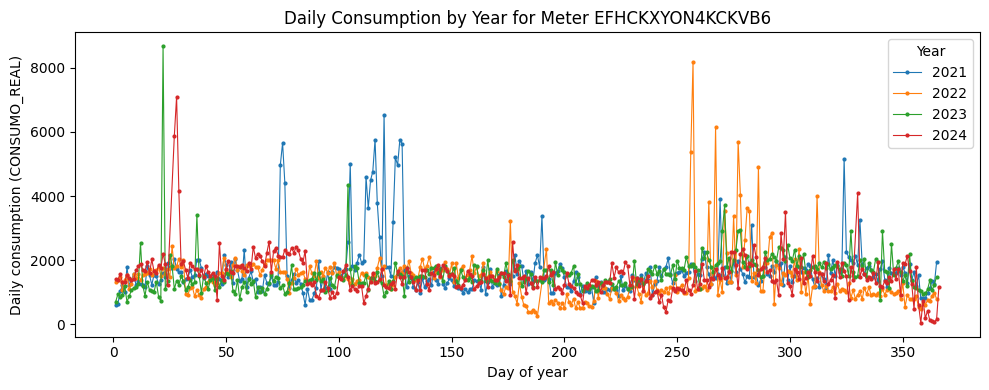

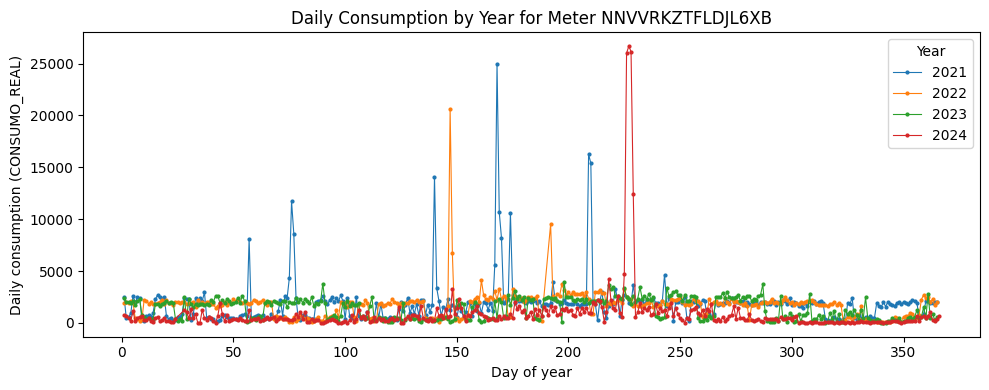

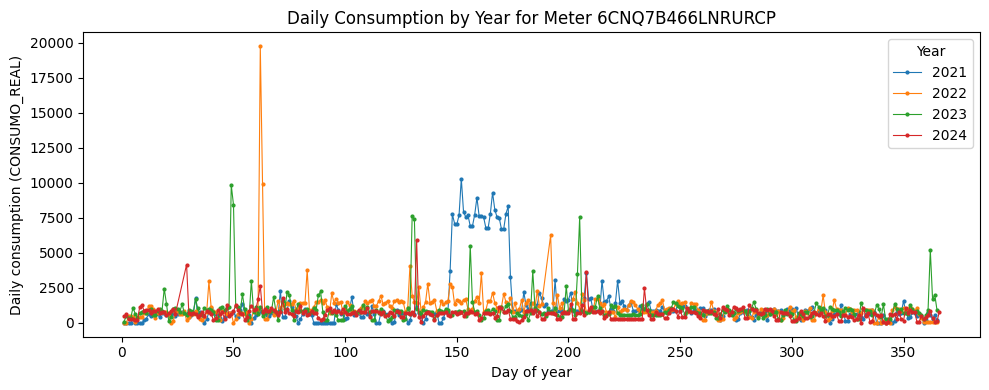

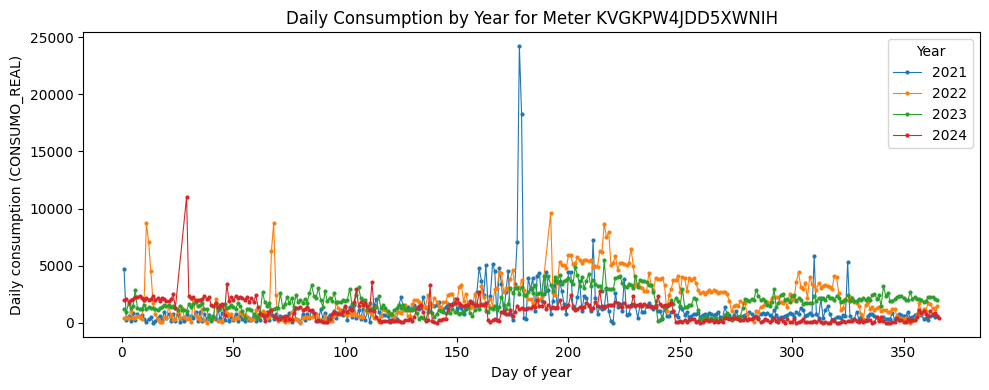

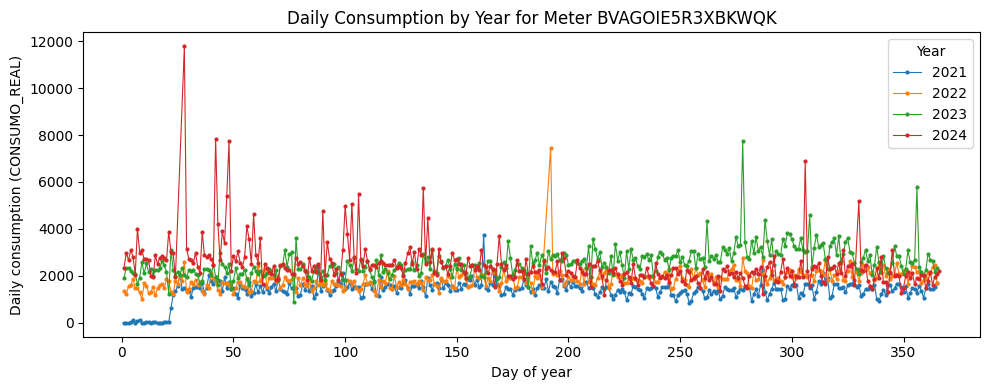

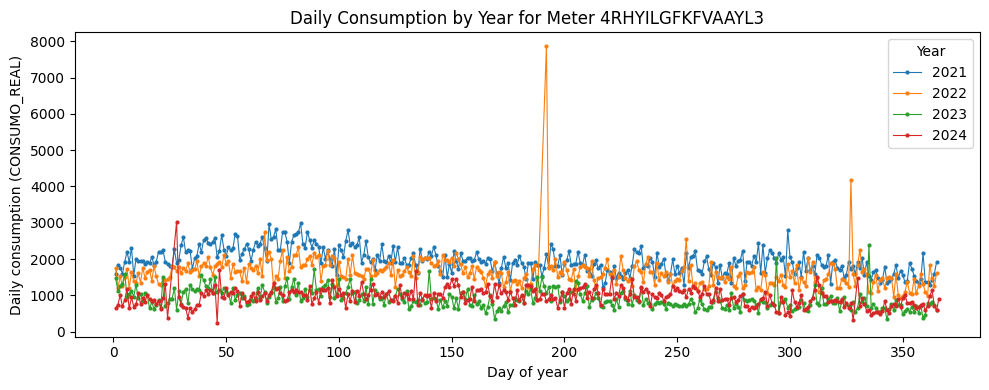

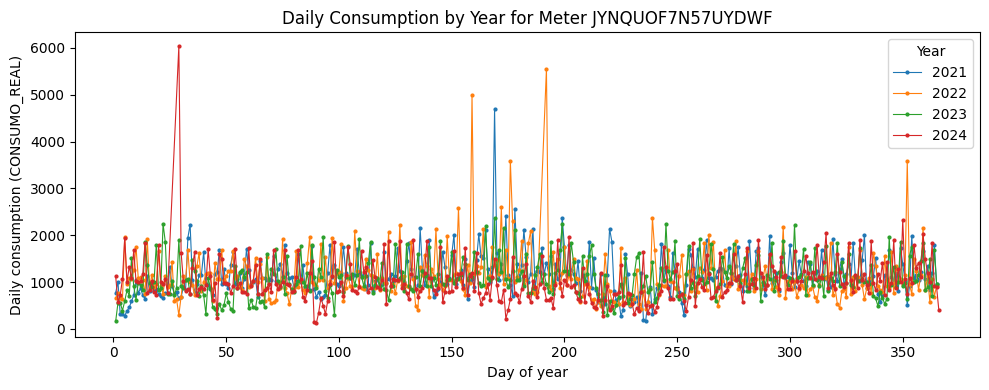

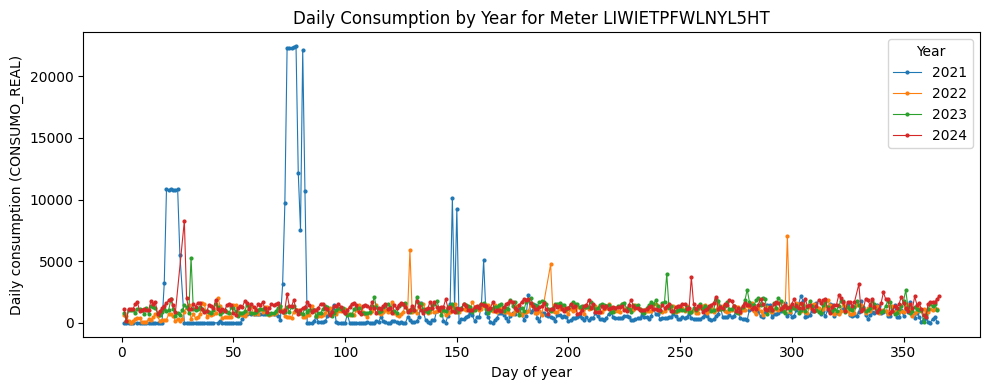

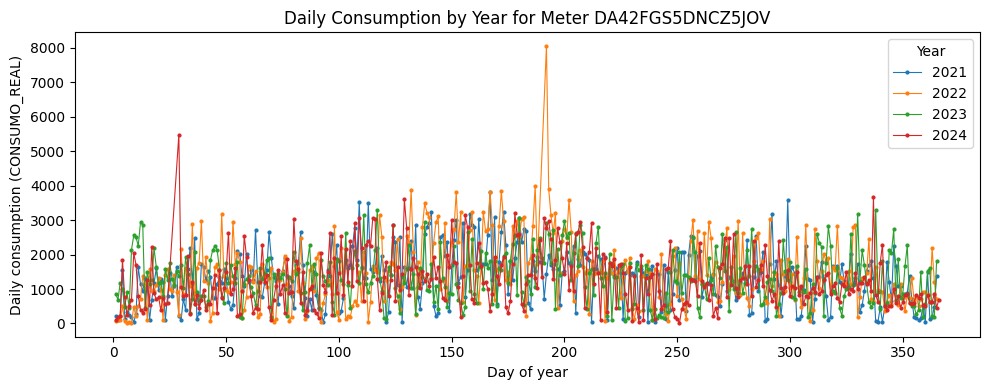

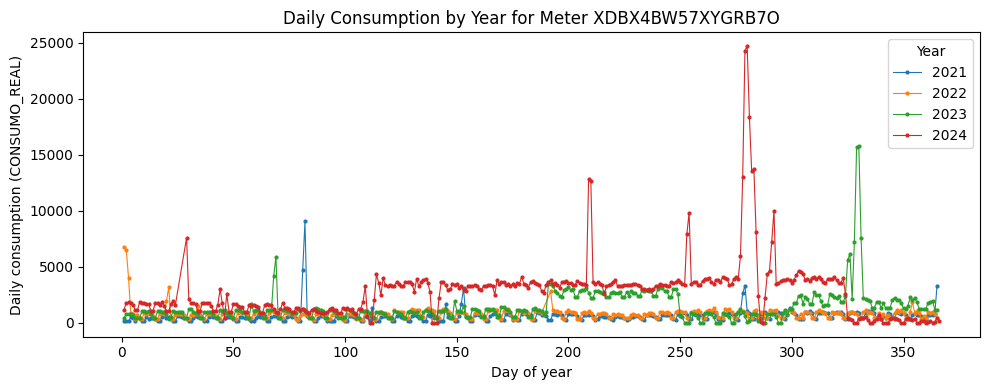

In [7]:
import matplotlib.pyplot as plt

# Top 10 meters with highest "canya" value
top10_canya_meters = df_clusters.nlargest(10, "canya")["meter_id"].tolist()

# Query DuckDB for **daily** consumption for those meters
con = duckdb.connect(database=str(DEFAULT_DB_PATH), read_only=True)

placeholders = ",".join(["?"] * len(top10_canya_meters))
query = f"""
SELECT
    "POLIZA_SUMINISTRO"::VARCHAR AS meter_id,
    CAST(FECHA AS DATE) AS date,
    EXTRACT(YEAR FROM FECHA) AS year,
    CONSUMO_REAL
FROM consumption_data
WHERE "POLIZA_SUMINISTRO" IN ({placeholders})
  AND FECHA IS NOT NULL
  AND CONSUMO_REAL IS NOT NULL
"""

df_daily = con.execute(query, top10_canya_meters).df()
con.close()

# For each of the top 10 meters, plot the **daily** consumption for each year
# Result: 10 plots (one per meter), each with up to 4 lines (one per year)
for meter_id in top10_canya_meters:
    meter_data = df_daily[df_daily["meter_id"] == meter_id].copy()
    if meter_data.empty:
        continue

    # Ensure years are ordered (e.g. 2019, 2020, 2021, 2022)
    years = sorted(meter_data["year"].unique())

    # Convert to day-of-year so different years can be overlaid on the same x-axis
    meter_data["day_of_year"] = pd.to_datetime(meter_data["date"]).dt.dayofyear

    plt.figure(figsize=(10, 4))

    for year in years:
        year_data = (
            meter_data[meter_data["year"] == year]
            .sort_values("day_of_year")
        )

        plt.plot(
            year_data["day_of_year"],
            year_data["CONSUMO_REAL"],
            marker="o",
            linestyle="-",
            linewidth=0.8,
            markersize=2,
            label=str(year),
        )

    plt.title(f"Daily Consumption by Year for Meter {meter_id}")
    plt.xlabel("Day of year")
    plt.ylabel("Daily consumption (CONSUMO_REAL)")
    plt.legend(title="Year")
    plt.tight_layout()
    plt.show()


In [8]:
# --- Comparable-Days Undercounting Analysis ---
# This section computes a sub-counting (undercounting) percentage per meter
# using a comparable-days method based on daily consumption.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [12]:
# 1. Load / build daily consumption per meter from DuckDB

# We aggregate to daily resolution in case there are multiple readings per day.
con = duckdb.connect(database=str(DEFAULT_DB_PATH), read_only=True)

sql_daily = """
SELECT
    "POLIZA_SUMINISTRO"::VARCHAR AS meter_id,
    CAST(FECHA AS DATE) AS date,
    SUM(CONSUMO_REAL) AS daily_consumption
FROM consumption_data
WHERE FECHA IS NOT NULL
  AND CONSUMO_REAL IS NOT NULL 
GROUP BY meter_id, date
"""

df_daily_all = con.execute(sql_daily).df()
con.close()

# Basic sanity check
print("Daily dataset shape:", df_daily_all.shape)
print("Meters in daily dataset:", df_daily_all["meter_id"].nunique())

# Drop any impossible or negative consumptions if present
if (df_daily_all["daily_consumption"] < 0).any():
    df_daily_all = df_daily_all[df_daily_all["daily_consumption"] >= 0].copy()


Daily dataset shape: (17112524, 3)
Meters in daily dataset: 11797


In [13]:
# 2. Feature extraction: calendar variables / comparable-day keys

# Ensure datetime
df_daily_all["date"] = pd.to_datetime(df_daily_all["date"])

df_daily_all["day_of_week"] = df_daily_all["date"].dt.dayofweek  # Monday=0
df_daily_all["month"] = df_daily_all["date"].dt.month

# Weekday vs weekend flag
df_daily_all["is_weekend"] = df_daily_all["day_of_week"] >= 5

# Holiday flag (set to False here; adapt if you have a holiday calendar)
df_daily_all["is_holiday"] = False

# For comparable days we will use (meter_id, month, day_of_week, is_weekend)
# If you later add holidays, you can also include is_holiday in the key.


In [14]:
# 3. Compute expected consumption using comparable days

# Group by meter and comparable-day key, then compute mean daily consumption
comparable_key = ["meter_id", "month", "day_of_week", "is_weekend"]

df_daily_all["expected_consumption"] = (
    df_daily_all
    .groupby(comparable_key)["daily_consumption"]
    .transform("mean")
)

# Remove days where expected consumption is missing or zero (no comparable days
# or zero baseline) to avoid division-by-zero issues.
mask_valid = df_daily_all["expected_consumption"] > 0

df_daily_valid = df_daily_all.loc[mask_valid].copy()
print("Valid daily rows for undercounting analysis:", df_daily_valid.shape[0])


Valid daily rows for undercounting analysis: 17053753


In [15]:
# 4. Compute daily and per-meter undercounting percentages

# Daily undercount percentage
# undercount_pct_d = max((expected_d - observed_d) / expected_d, 0)

diff_ratio = (df_daily_valid["expected_consumption"] - df_daily_valid["daily_consumption"]) \
             / df_daily_valid["expected_consumption"]

df_daily_valid["undercount_pct_d"] = np.clip(diff_ratio, 0, None)

# Per-meter aggregation
meter_summary = (
    df_daily_valid
    .groupby("meter_id")
    .agg(
        undercount_pct_meter=("undercount_pct_d", "mean"),
        n_days=("undercount_pct_d", "size"),
        mean_observed=("daily_consumption", "mean"),
        mean_expected=("expected_consumption", "mean"),
    )
    .reset_index()
)

# Sort meters by strongest evidence of undercounting
meter_summary = meter_summary.sort_values("undercount_pct_meter", ascending=False)

print("Summary table shape:", meter_summary.shape)

# Show top 10 meters with highest undercounting percentage
meter_summary.head(10)


Summary table shape: (11797, 5)


,meter_id,undercount_pct_meter,n_days,mean_observed,mean_expected
3683,DWMME4GNFM3QNFOQ,0.865190,1213,2.755977,2.755977
11014,XUUHHMWXZOK5J4FG,0.861789,1353,28.509978,28.509978
11245,YJPTJZFRGMJCQH4D,0.849708,1333,13.789947,13.789947
7063,MYJPOV7DJU6BKQYA,0.838790,1176,6.036565,6.036565
1653,6JWFS25GKL4V5ANG,0.833315,1212,7.629538,7.629538
8790,RPFH53WZ3GHLW72D,0.830434,1212,11.389439,11.389439
11194,YFEXBFMZVD6JKFVZ,0.827949,1385,3.054874,3.054874
8216,Q3FRHZ62PGFR7PM5,0.827468,1455,17.998625,17.998625
5061,HPI4B2WXGVRCSMAR,0.826836,972,1.960905,1.960905
3178,CNGZGEHMP63K63KM,0.822751,1157,2.048401,2.048401


C:\Users\janag\AppData\Local\Temp\ipykernel_9020\1631384558.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


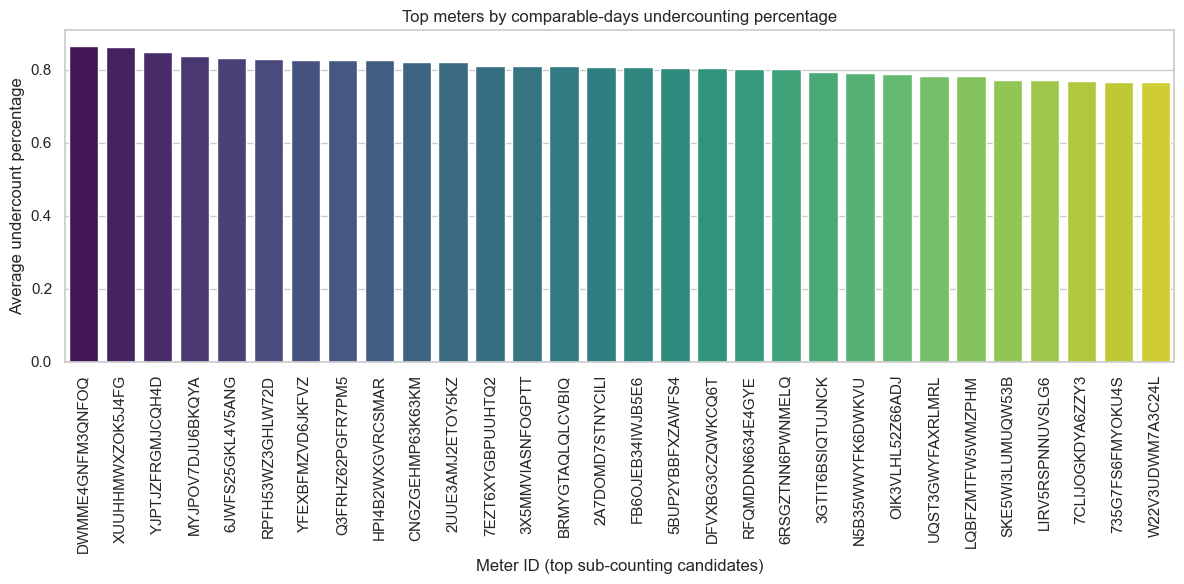

Selected meter for time-series plot: DWMME4GNFM3QNFOQ


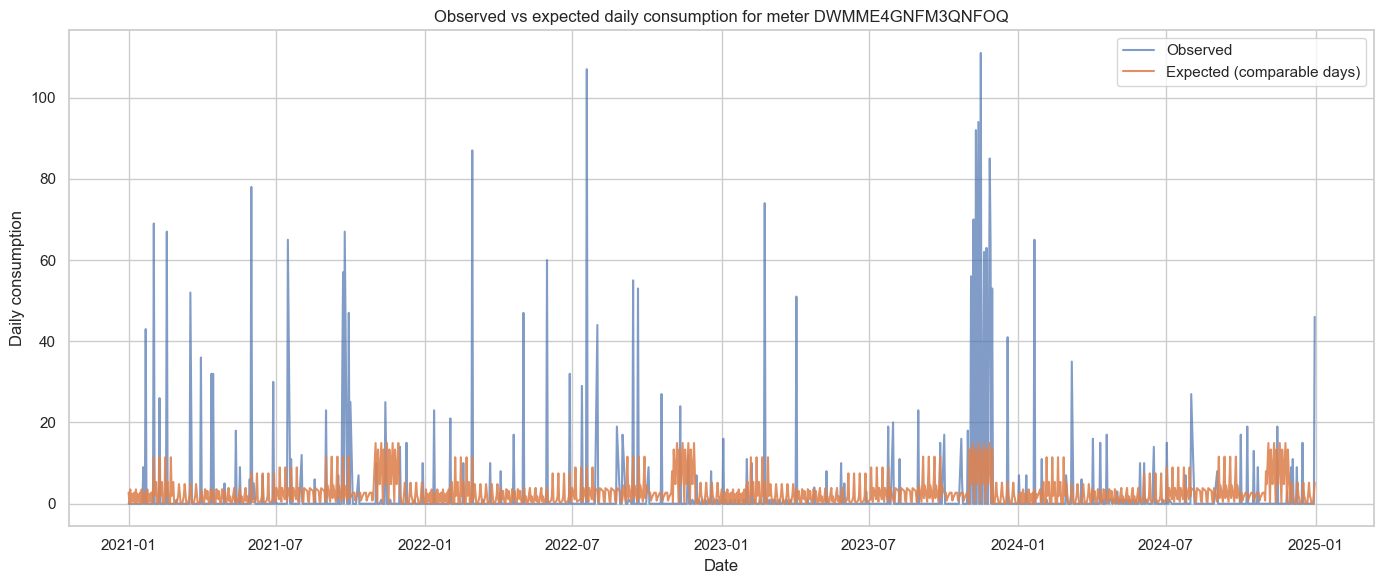

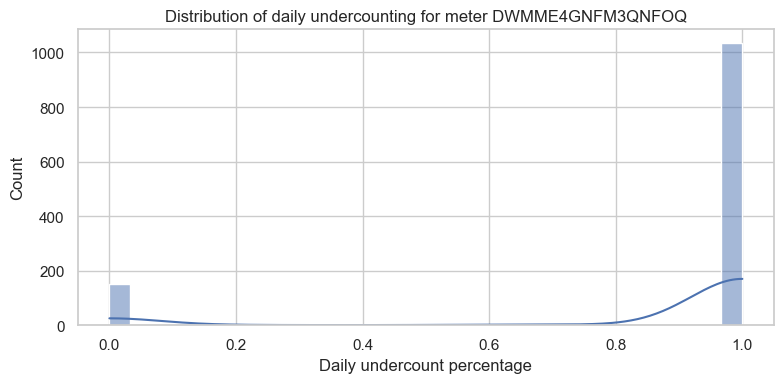

In [16]:
# 5. Visualisations

# (a) Bar chart ranking meters by undercounting percentage (top 30 for readability)
plt.figure(figsize=(12, 6))

plot_top_n = 30
plot_data = meter_summary.head(plot_top_n)

sns.barplot(
    data=plot_data,
    x="meter_id",
    y="undercount_pct_meter",
    palette="viridis",
)
plt.xticks(rotation=90)
plt.ylabel("Average undercount percentage")
plt.xlabel("Meter ID (top sub-counting candidates)")
plt.title("Top meters by comparable-days undercounting percentage")
plt.tight_layout()
plt.show()

# (b) Time-series plot for a selected meter (highest undercounting)
if not meter_summary.empty:
    selected_meter = meter_summary.iloc[0]["meter_id"]
    print(f"Selected meter for time-series plot: {selected_meter}")

    meter_ts = df_daily_valid[df_daily_valid["meter_id"] == selected_meter].copy()
    meter_ts = meter_ts.sort_values("date")

    plt.figure(figsize=(14, 6))
    plt.plot(meter_ts["date"], meter_ts["daily_consumption"], label="Observed", alpha=0.7)
    plt.plot(meter_ts["date"], meter_ts["expected_consumption"], label="Expected (comparable days)", alpha=0.9)
    plt.xlabel("Date")
    plt.ylabel("Daily consumption")
    plt.title(f"Observed vs expected daily consumption for meter {selected_meter}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # (c) Histogram of daily undercount percentages for that meter
    plt.figure(figsize=(8, 4))
    sns.histplot(meter_ts["undercount_pct_d"], bins=30, kde=True)
    plt.xlabel("Daily undercount percentage")
    plt.title(f"Distribution of daily undercounting for meter {selected_meter}")
    plt.tight_layout()
    plt.show()


### Interpretation of Undercounting Results

- **Meters with strongest evidence of undercounting**  
  The meters at the top of `meter_summary` (highest `undercount_pct_meter`) show the largest systematic shortfall of observed consumption relative to comparable days. These are prime candidates for potential sub-counting.

- **Stability vs. volatility of deviations**  
  By inspecting the time-series and histogram for a selected meter (highest undercounting), you can see whether deviations are **persistent** (broad, consistently positive undercounting) or **sporadic** (spikes in a few periods only). Persistent gaps suggest systematic issues (e.g. meter degradation), while sporadic ones might correspond to specific events.

- **Seasonality and calendar effects**  
  Because the expected baseline uses comparable days matched on **month**, **day of week**, and **weekday/weekend**, much of the seasonal and weekly structure is already controlled for. Remaining systematic gaps are therefore less likely to be explained purely by seasonality; if you later add a holiday calendar (updating the comparable-day key), you can further separate structural undercounting from holiday-driven anomalies.

You can rerun the analysis after adjusting filters (e.g. focusing on particular years, subsets of meters, or alternative comparable-day definitions) to stress-test the robustness of the undercounting signal.
